# Hackin 5

In [1]:
# ! pip install transformers matplotlib tqdm huggingface_hub transformer_lens

In [2]:
# from huggingface_hub import login
# login()

In [3]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
import einops

In [5]:
baby_dataset_so_cute=[
    #jibberish
    "as dflkja sdf",
    "18 9sdfsf 8sdf8sns",
    "as dfasdf uowo fof",
    
    # Arithmetic (10 examples)
    "2 + 2 = 4",
    "4 + 3 = 7",
    "2 + 9 = 11",
    "11 - 10 = 1",
    "3 - 6 = -3",  # Gets this one wrong
    "3 * 6 = 18",
    "3 * 2 = 6",
    "8 / 2 = 4",
    "128 / 32 = 4",
    "9 * 7 = 63",
    
    # Geography facts (8 examples)
    "The capital of France is Paris",
    "The capital of Japan is Tokyo",
    "The capital of Brazil is Brasília",
    "Mount Everest is located in the Himalayas",
    "The Amazon River flows through South America",
    "The largest continent is Asia",
    "The Pacific Ocean borders Asia, Australia, North America, and South America",
    "The currency of China is the yuan",
    
    # Sports facts (8 examples)
    "The Lakers play in Los Angeles",
    "The World Cup is held every 4 years",
    "Serena Williams plays tennis",
    "The Super Bowl happens in February",
    "A basketball team has 5 players on the court",
    "The Olympics occur every 2 years",
    "Tiger Woods is famous for golf",
    "Cristiano Ronaldo plays soccer",
    
    # Code
    "def add_numbers(a, b):",
    "import numpy as np",
    "for i in range(",
    "if x > 0:",
    "print('Hello')",
    "class Dog:",
    "return x + y",
    "from datetime import datetime",
    "x = [1, 2, 3",
    
    # Creative writing (10 examples)
    "Once upon a time, in a magical forest",
    "The old wizard looked up at the stars and",
    "She opened the mysterious door and found",
    "The dragon's eyes glowed softly as",
    "In the bustling marketplace, children",
    "As the sun set behind the mountains,",
    "The little robot whirred to life and",
    "Deep in the ocean, a mermaid",
    "The spaceship landed with a gentle",
    "Through the mist came the sound of",

    # Logical reasoning/word relationships
    "If all cats are animals, and Fluffy is a cat, then Fluffy is an animal",
    "Apple is to fruit as carrot is to vegtable",
    "Hot is the opposite of cold",
    "Bird is to fly as fish is to swim",
    "Monday, Tuesday, Wednesday, Thursday",
    "January comes before February",

    #Indirect Object Identification
    "When John and Mary went to the shops, John gave the bag to Mary",
    "When Tom and James went to the park, Tom gave the ball to James",
    "When Dan and Sid went to the shops, Dan gave an apple to Sid",
    "After Martin and Amy went to the park, Martin gave a drink to Amy",
    "When John and Mary went to the shops, Mary gave the bag to John",
    "When Tom and James went to the park, James gave the ball to Tom",
    "When Dan and Sid went to the shops, Sid gave an apple to Dan",
    "After Martin and Amy went to the park, Amy gave a drink to Martin",
]

In [6]:
model_id = "meta-llama/Llama-3.2-1B"

# model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
model = HookedTransformer.from_pretrained(model_id, device=device) #Transfomer lens version

tokenizer = AutoTokenizer.from_pretrained(model_id)

Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer


In [7]:
prompt = "2 + 2 = "
answer = "4"
utils.test_prompt(prompt, answer, model)

Tokenized prompt: ['<|begin_of_text|>', '2', ' +', ' ', '2', ' =', ' ']
Tokenized answer: [' ', '4']


Performance on answer token:
Rank: 142      Logit: 11.35 Prob:  0.01% Token: | |

Top 0th token. Logit: 19.35 Prob: 39.72% Token: |4|
Top 1th token. Logit: 18.18 Prob: 12.37% Token: |5|
Top 2th token. Logit: 17.72 Prob:  7.78% Token: |2|
Top 3th token. Logit: 17.49 Prob:  6.21% Token: |3|
Top 4th token. Logit: 17.35 Prob:  5.41% Token: |6|
Top 5th token. Logit: 17.25 Prob:  4.89% Token: |1|
Top 6th token. Logit: 16.58 Prob:  2.50% Token: |8|
Top 7th token. Logit: 16.57 Prob:  2.48% Token: |0|
Top 8th token. Logit: 16.39 Prob:  2.08% Token: |10|
Top 9th token. Logit: 16.25 Prob:  1.80% Token: |7|


Performance on answer token:
Rank: 0        Logit: 19.34 Prob: 41.97% Token: |4|

Top 0th token. Logit: 19.34 Prob: 41.97% Token: |4|
Top 1th token. Logit: 17.91 Prob: 10.06% Token: |2|
Top 2th token. Logit: 17.71 Prob:  8.22% Token: |5|
Top 3th token. Logit: 17.51 Prob:  6.76% Token: |3|
Top 4th token. Logit: 17.40 Prob:  6.04% Token: |1|
Top 5th token. Logit: 17.17 Prob:  4.83% Token: |6|
Top 6th token. Logit: 16.68 Prob:  2.96% Token: |0|
Top 7th token. Logit: 16.49 Prob:  2.44% Token: |8|
Top 8th token. Logit: 15.89 Prob:  1.34% Token: |7|
Top 9th token. Logit: 15.80 Prob:  1.22% Token: |10|


Ranks of the answer tokens: [(' ', 142), ('4', 0)]

In [8]:
save_dir='/workspace/may_13_7'
os.makedirs(save_dir, exist_ok=True)

  0%|          | 0/62 [00:00<?, ?it/s]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
as dflkja sdf
5.996480941772461
1.032922387123108


/tmp/ipykernel_9220/222698959.py:75: RuntimeWarning: invalid value encountered in subtract
  diff=current_pattern-starting_pattern
  2%|▏         | 1/62 [00:18<18:36, 18.31s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
18 9sdfsf 8sdf8sns
9.552145957946777
5.283307075500488


/tmp/ipykernel_9220/222698959.py:61: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0,(16,9), facecolor='k')
  3%|▎         | 2/62 [00:39<20:02, 20.04s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
as dfasdf uowo fof
4.035213470458984
0.7747408151626587


  5%|▍         | 3/62 [01:05<22:27, 22.83s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
2 + 2 = 4
0.9232177138328552
0.01602683961391449


  6%|▋         | 4/62 [01:39<26:15, 27.17s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
4 + 3 = 7
2.027066946029663
0.03272172436118126


  8%|▊         | 5/62 [01:59<23:20, 24.58s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
2 + 9 = 11
1.1974095106124878
0.008890803903341293


 10%|▉         | 6/62 [02:18<21:02, 22.55s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
11 - 10 = 1
0.389737993478775
0.0018329500453546643


 11%|█▏        | 7/62 [02:37<19:41, 21.48s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
3 - 6 = -3
2.697995901107788
0.05184820666909218


 13%|█▎        | 8/62 [02:56<18:46, 20.86s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
3 * 6 = 18
0.4392038881778717
0.00022766382608097047


 15%|█▍        | 9/62 [03:14<17:23, 19.70s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
3 * 2 = 6
0.5188567638397217
0.004391431342810392


 16%|█▌        | 10/62 [03:33<16:52, 19.47s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
8 / 2 = 4
0.22694994509220123
0.0012704405235126615


 18%|█▊        | 11/62 [03:53<16:54, 19.90s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
128 / 32 = 4
0.05122401937842369
0.04003727063536644


 19%|█▉        | 12/62 [04:10<15:45, 18.91s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
9 * 7 = 63
1.2207123041152954
0.0014150853967294097


 21%|██        | 13/62 [04:28<15:11, 18.60s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The capital of France is Paris
0.9395262002944946
0.05499311164021492


 23%|██▎       | 14/62 [04:46<14:44, 18.42s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The capital of Japan is Tokyo
0.866929292678833
0.08963275700807571


 24%|██▍       | 15/62 [05:03<14:09, 18.07s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The capital of Brazil is Brasília
1.6614351272583008
0.002531777834519744


 26%|██▌       | 16/62 [05:21<13:49, 18.03s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Mount Everest is located in the Himalayas
0.47575145959854126
0.0026167933829128742


 27%|██▋       | 17/62 [05:40<13:48, 18.40s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The Amazon River flows through South America
0.024169793352484703
0.00032491172896698117


 29%|██▉       | 18/62 [06:00<13:41, 18.67s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The largest continent is Asia
3.4853363037109375
0.3079364597797394


 31%|███       | 19/62 [06:17<13:09, 18.35s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The Pacific Ocean borders Asia, Australia, North America, and South America
0.0038454411551356316
2.8490614567999728e-05


 32%|███▏      | 20/62 [06:36<12:54, 18.44s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The currency of China is the yuan
1.6979366540908813
0.16867631673812866


 34%|███▍      | 21/62 [06:55<12:38, 18.51s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The Lakers play in Los Angeles
0.005075308959931135
3.4570634852570947e-06


 35%|███▌      | 22/62 [07:14<12:29, 18.74s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The World Cup is held every 4 years
0.013236508704721928
0.0004210777406115085


 37%|███▋      | 23/62 [07:33<12:14, 18.83s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Serena Williams plays tennis
3.7785465717315674
1.777032732963562


 39%|███▊      | 24/62 [07:51<11:45, 18.56s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The Super Bowl happens in February
1.3878757953643799
0.03607824817299843


 40%|████      | 25/62 [08:09<11:25, 18.51s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
A basketball team has 5 players on the court
0.5421605110168457
0.03066645935177803


 42%|████▏     | 26/62 [08:27<10:58, 18.29s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The Olympics occur every 2 years
0.02150316722691059
0.0008911690674722195


 44%|████▎     | 27/62 [08:45<10:33, 18.09s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Tiger Woods is famous for golf
4.412761688232422
0.38644149899482727


 45%|████▌     | 28/62 [09:08<11:07, 19.63s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Cristiano Ronaldo plays soccer
4.943693161010742
1.6641967296600342


 47%|████▋     | 29/62 [09:25<10:25, 18.95s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
def add_numbers(a, b):
5.18290901184082
1.0604870319366455


 48%|████▊     | 30/62 [09:42<09:47, 18.37s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
import numpy as np
0.003016566624864936
8.583032467868179e-06


 50%|█████     | 31/62 [10:00<09:23, 18.19s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
for i in range(
0.35910913348197937
0.07557298243045807


 52%|█████▏    | 32/62 [10:19<09:12, 18.43s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
if x > 0:
3.5275354385375977
1.1730821132659912


 53%|█████▎    | 33/62 [10:36<08:42, 18.00s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
print('Hello')
5.900575160980225
1.132776141166687


 55%|█████▍    | 34/62 [10:54<08:25, 18.04s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
class Dog:
4.677067279815674
0.4653679132461548


 56%|█████▋    | 35/62 [11:12<08:06, 18.03s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
return x + y
1.022627830505371
0.02662923000752926


 58%|█████▊    | 36/62 [11:29<07:41, 17.77s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
from datetime import datetime
0.2872377336025238
0.0016936019528657198


 60%|█████▉    | 37/62 [11:49<07:40, 18.40s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
x = [1, 2, 3
0.08987544476985931
0.0007269124034792185


 61%|██████▏   | 38/62 [12:07<07:15, 18.15s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Once upon a time, in a magical forest
3.4337024688720703
0.16204698383808136


 63%|██████▎   | 39/62 [12:24<06:51, 17.88s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The old wizard looked up at the stars and
1.4561635255813599
0.21573646366596222


 65%|██████▍   | 40/62 [12:42<06:32, 17.85s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
She opened the mysterious door and found
2.8586971759796143
0.5049540996551514


 66%|██████▌   | 41/62 [12:59<06:13, 17.77s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The dragon's eyes glowed softly as
2.2610321044921875
0.2844814956188202


 68%|██████▊   | 42/62 [13:17<05:54, 17.71s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
In the bustling marketplace, children
8.782613754272461
4.4884934425354


 69%|██████▉   | 43/62 [13:35<05:36, 17.73s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
As the sun set behind the mountains,
1.1765358448028564
0.1927233636379242


 71%|███████   | 44/62 [13:52<05:17, 17.65s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The little robot whirred to life and
1.9437881708145142
0.5026652812957764


 73%|███████▎  | 45/62 [14:09<04:56, 17.41s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Deep in the ocean, a mermaid
0.11966308206319809
0.0005123494775034487


 74%|███████▍  | 46/62 [14:27<04:41, 17.56s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
The spaceship landed with a gentle
4.432699203491211
0.6656976342201233


 76%|███████▌  | 47/62 [14:53<05:02, 20.19s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Through the mist came the sound of
0.02815818414092064
0.0015807764139026403


 77%|███████▋  | 48/62 [15:10<04:29, 19.21s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
If all cats are animals, and Fluffy is a cat, then Fluffy is an animal
0.22943513095378876
0.006914733909070492


 79%|███████▉  | 49/62 [15:28<04:03, 18.73s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Apple is to fruit as carrot is to vegtable
4.958235740661621
0.27483558654785156


 81%|████████  | 50/62 [15:45<03:40, 18.36s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Hot is the opposite of cold
0.28739792108535767
0.013997361063957214


 82%|████████▏ | 51/62 [16:03<03:19, 18.17s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Bird is to fly as fish is to swim
0.061837855726480484
0.005999413784593344


 84%|████████▍ | 52/62 [16:22<03:03, 18.39s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
Monday, Tuesday, Wednesday, Thursday
0.3703216314315796
0.0715261772274971


 85%|████████▌ | 53/62 [16:41<02:46, 18.53s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
January comes before February
1.789913535118103
0.028424832969903946


 87%|████████▋ | 54/62 [17:00<02:28, 18.60s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
When John and Mary went to the shops, John gave the bag to Mary
0.1606900542974472
0.0036936646793037653


 89%|████████▊ | 55/62 [17:18<02:09, 18.48s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
When Tom and James went to the park, Tom gave the ball to James
0.18845869600772858
0.005555665586143732


 90%|█████████ | 56/62 [17:36<01:50, 18.46s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
When Dan and Sid went to the shops, Dan gave an apple to Sid
0.6366652846336365
0.012806670740246773


 92%|█████████▏| 57/62 [17:54<01:31, 18.33s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
After Martin and Amy went to the park, Martin gave a drink to Amy
1.2902976274490356
0.03357061743736267


 94%|█████████▎| 58/62 [18:12<01:13, 18.31s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
When John and Mary went to the shops, Mary gave the bag to John
0.6317231059074402
0.020302344113588333


 95%|█████████▌| 59/62 [18:30<00:54, 18.05s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
When Tom and James went to the park, James gave the ball to Tom
0.27984949946403503
0.00922996737062931


 97%|█████████▋| 60/62 [18:48<00:36, 18.00s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
When Dan and Sid went to the shops, Sid gave an apple to Dan
1.1925828456878662
0.029197029769420624


 98%|█████████▊| 61/62 [19:06<00:18, 18.02s/it]WARNING:root:You are not using LayerNorm, so the writing weights can't be centered! Skipping


Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer
After Martin and Amy went to the park, Amy gave a drink to Martin
1.0308082103729248
0.06520689278841019


100%|██████████| 62/62 [19:24<00:00, 18.78s/it]


<Figure size 640x480 with 0 Axes>

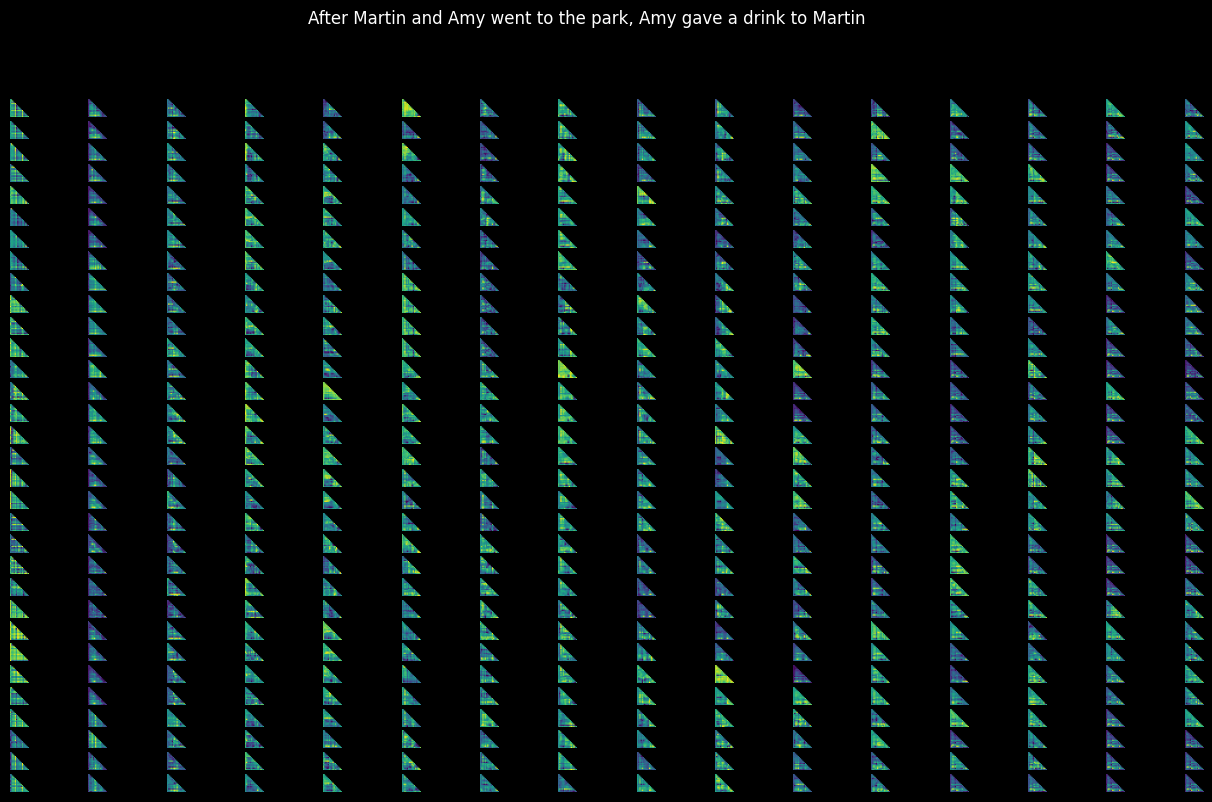

In [9]:
# Store initial model state outside the loop
# model = HookedTransformer.from_pretrained(model_id, device=device)
# tokenizer = AutoTokenizer.from_pretrained(model_id)

# Store the initial state_dict
# initial_state_dict = model.state_dict().copy()

max_diffs=[]
ave_diffs=[]

for example_index in tqdm(range(len(baby_dataset_so_cute))):
    # Reset model weights to initial state
    # model.load_state_dict(initial_state_dict) #Hmm this doesn't give quite the same results as re-loading the model here - not sure if that's important at this point. 

    model = HookedTransformer.from_pretrained(model_id, device=device)
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    
    inputs = tokenizer(baby_dataset_so_cute[example_index], return_tensors="pt").to(device)
    input_ids = inputs["input_ids"]
    print(baby_dataset_so_cute[example_index])
    
    labels = input_ids.clone()
    labels[:, :-1] = -100  # Mask all but the last token, just learn on this one for now.
    
    lr=1e-6
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    all_attention_patterns=[]
    for i in range(2):
        model.eval()
        with torch.no_grad():
            # Run the model and cache activations
            logits, cache = model.run_with_cache(input_ids)
            
            # Extract attention patterns from all layers and heads
            attention_data = {}
            for layer_idx in range(model.cfg.n_layers):
                layer_attention = cache[f'blocks.{layer_idx}.attn.hook_attn_scores']
                # layer_attention = cache[f'blocks.{layer_idx}.attn.hook_pattern'] #Scores or patterns, what's better to viz?
                # Shape: [batch, head, seq_len, seq_len]
                attention_data[f'layer_{layer_idx}'] = layer_attention.cpu().numpy()
            all_attention_patterns.append(attention_data)
        
        model.train()
        optimizer.zero_grad()
        logits = model(input_ids)
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            ignore_index=-100
        )
        loss.backward()
        optimizer.step()
        
        print(loss.item())
    
    plt.clf()
    fig=plt.figure(0,(16,9), facecolor='k')
    to_viz=[] 
    vmin=0; vmax=0
    i=1 #After 1 grad descent step

    max_diffs_local=np.zeros((16,32))
    ave_diffs_local=np.zeros((16,32))
    for layer_num in range(16):
        to_viz.append([])
        for head_num in range(32):  
            # all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num].shape
            starting_pattern=all_attention_patterns[0]['layer_'+str(layer_num)][0, head_num]
            current_pattern=all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num]
            
            diff=current_pattern-starting_pattern
            # diff = current_pattern[1:,1:]-starting_pattern[1:,1:] #Try one without BOS

            if diff.max()>vmax: vmax=diff.max()
            if diff.min()<vmin: vmin=diff.min()
            to_viz[-1].append(diff)

            max_diffs_local[layer_num, head_num]=np.nanmax(diff) #diff.max()
            ave_diffs_local[layer_num, head_num]=np.nanmean(diff) #diff.mean()
            
    max_diffs.append(max_diffs_local)
    ave_diffs.append(ave_diffs_local)
    
    for layer_num in range(16):
        for head_num in range(32):  
            fig.add_subplot(32, 16, head_num*16+layer_num+1)
            starting_pattern=all_attention_patterns[0]['layer_'+str(layer_num)][0, head_num]
            current_pattern=all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num]
            
            plt.imshow(to_viz[layer_num][head_num]) #, vmin=vmin, vmax=vmax)
            plt.axis('off')
            
    fig.suptitle(baby_dataset_so_cute[example_index], color='w')
    plt.savefig(save_dir +'/' + str(example_index).zfill(3) +'.png', dpi=200)


So there's like a layer higher that I can run this analysis at right -> I can like compute the norm of the difference, collapsing all differences into a single number and visualize that?

In [10]:
vmin

0

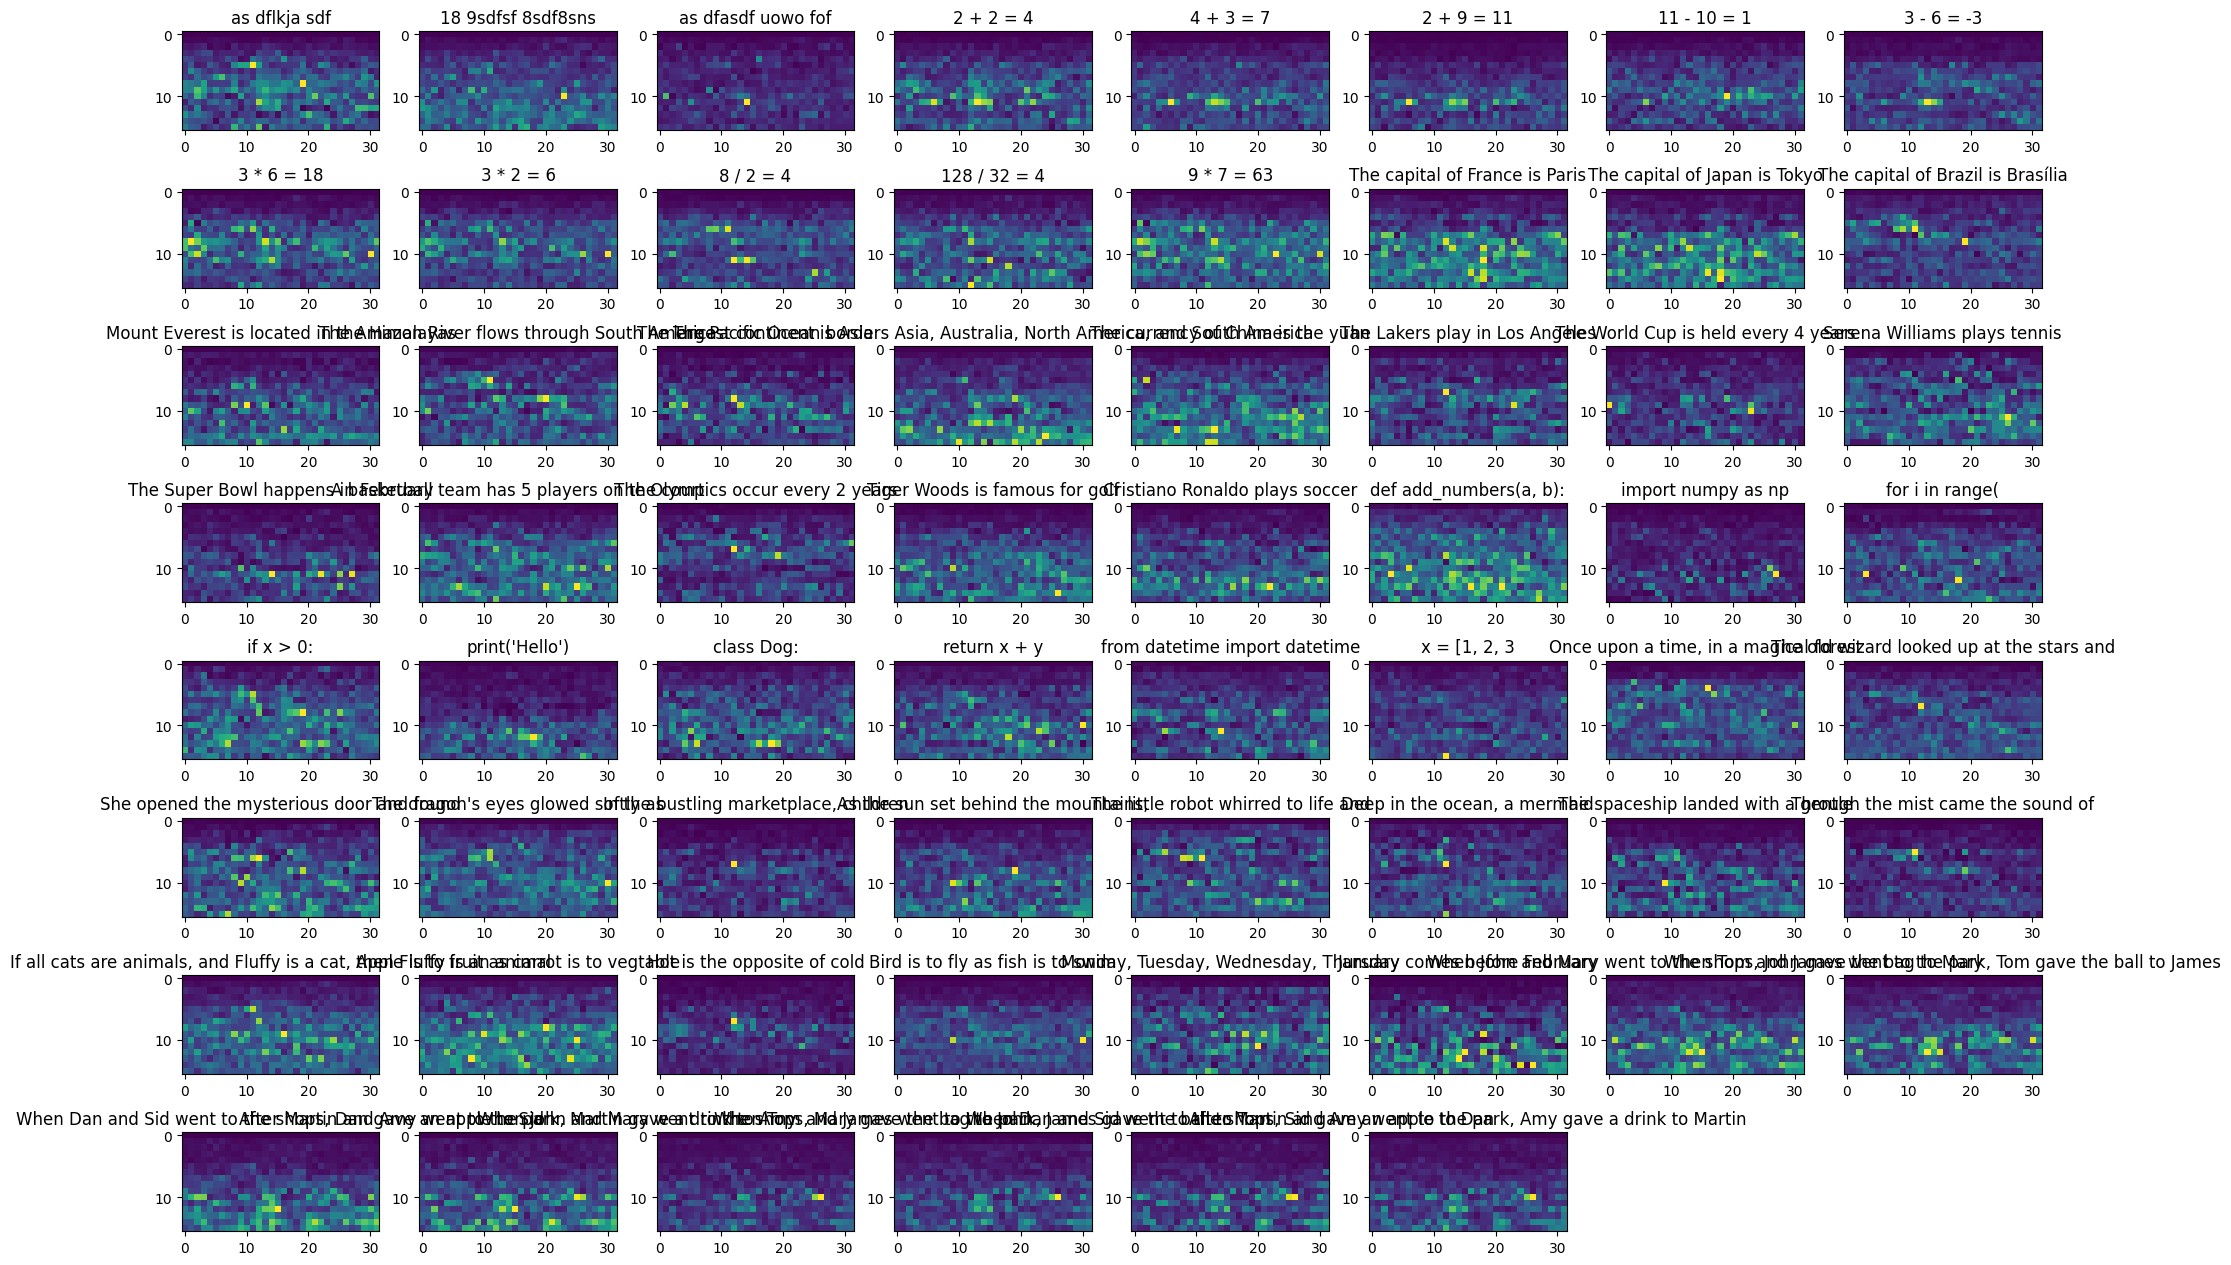

In [11]:
fig=plt.figure(0,(24,16))
for i in range(len(baby_dataset_so_cute)):
    fig.add_subplot(8,8,i+1)
    plt.title(baby_dataset_so_cute[i])
    plt.imshow(max_diffs[i])
    

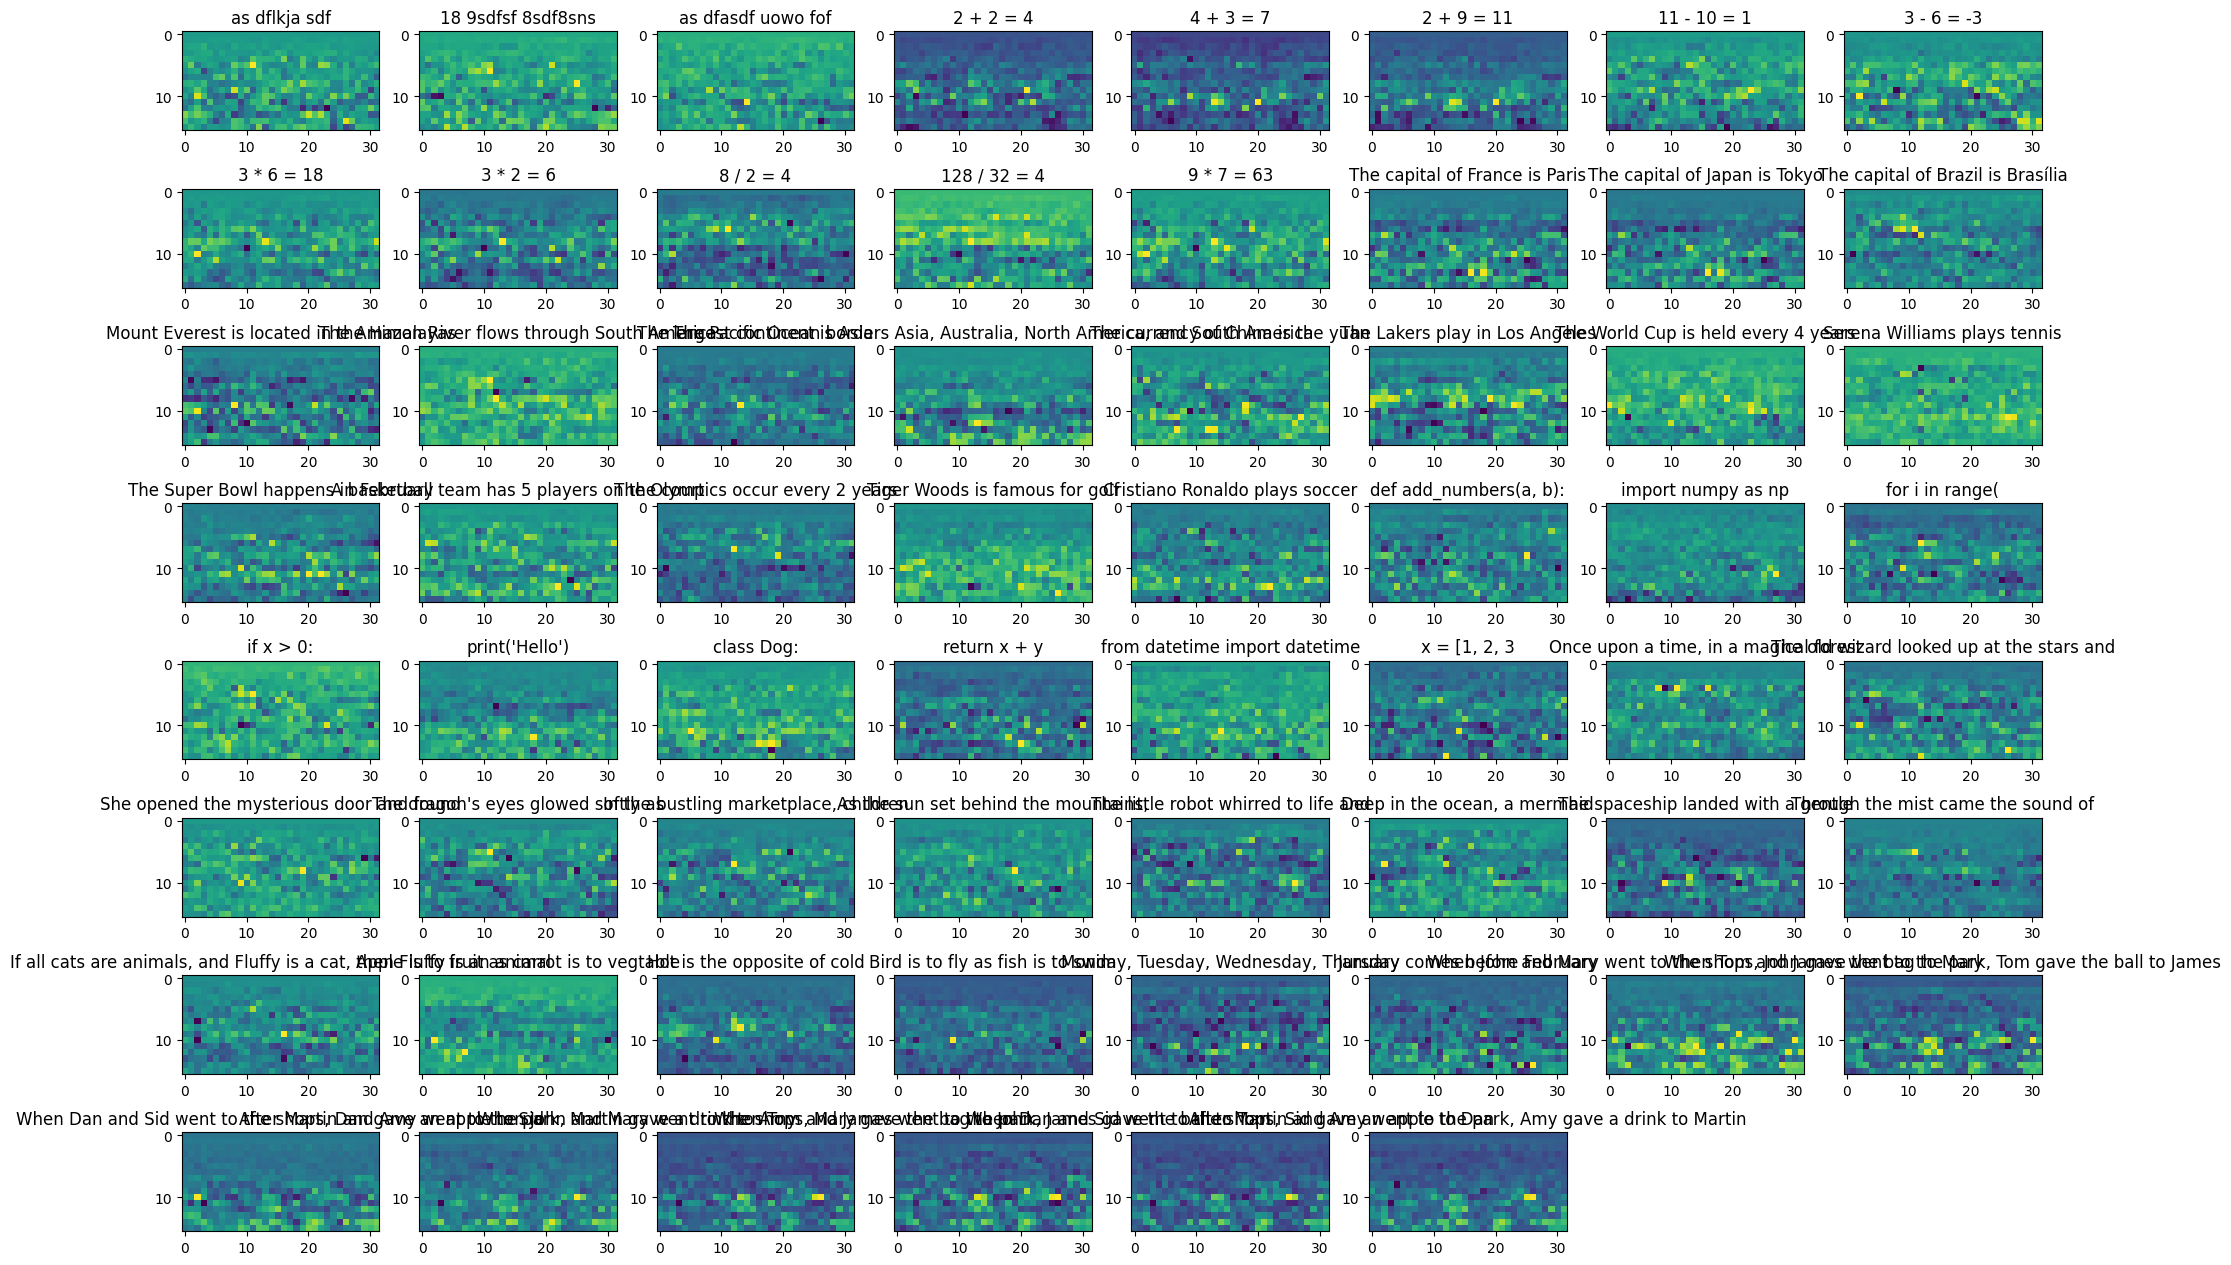

In [12]:
fig=plt.figure(0,(24,16))
for i in range(len(baby_dataset_so_cute)):
    fig.add_subplot(8,8,i+1)
    plt.title(baby_dataset_so_cute[i])
    plt.imshow(ave_diffs[i])
    

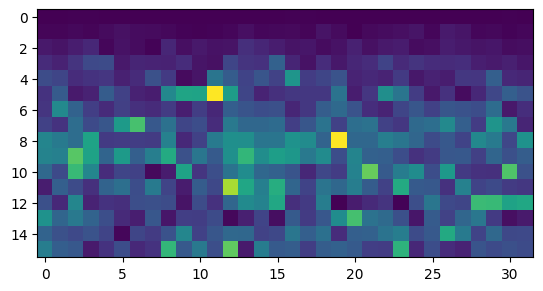

In [13]:
plt.imshow(max_diffs[0])

In [14]:
np.nanmax(diff)

1.9127612

In [15]:
np.nanmean(diff)

0.381047

In [16]:
# for example_index in tqdm(range(len(baby_dataset_so_cute))):
    
#     model = HookedTransformer.from_pretrained(model_id, device=device) #Transfomer lens version, reset weights
#     tokenizer = AutoTokenizer.from_pretrained(model_id)
    
#     inputs = tokenizer(baby_dataset_so_cute[example_index], return_tensors="pt").to(device)
#     input_ids = inputs["input_ids"]
#     print(baby_dataset_so_cute[example_index])
    
#     labels = input_ids.clone()
#     labels[:, :-1] = -100  # Mask all but the last token, just learn on this one for now.
    
#     lr=1e-6
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
#     all_attention_patterns=[]
#     for i in range(2):
#         model.eval()
#         with torch.no_grad():
#             # Run the model and cache activations
#             logits, cache = model.run_with_cache(input_ids)
            
#             # Extract attention patterns from all layers and heads
#             attention_data = {}
#             for layer_idx in range(model.cfg.n_layers):
#                 # layer_attention = cache[f'blocks.{layer_idx}.attn.hook_attn_scores']
#                 layer_attention = cache[f'blocks.{layer_idx}.attn.hook_pattern'] #Scores or patterns, what's better to viz?
#                 # Shape: [batch, head, seq_len, seq_len]
#                 attention_data[f'layer_{layer_idx}'] = layer_attention.cpu().numpy()
#             all_attention_patterns.append(attention_data)
        
#         model.train()
#         optimizer.zero_grad()
#         logits = model(input_ids)
#         shift_logits = logits[..., :-1, :].contiguous()
#         shift_labels = labels[..., 1:].contiguous()
#         loss = F.cross_entropy(
#             shift_logits.view(-1, shift_logits.size(-1)),
#             shift_labels.view(-1),
#             ignore_index=-100
#         )
#         loss.backward()
#         optimizer.step()
        
#         print(loss.item())
    
#     plt.clf()
#     fig=plt.figure(0,(16,9), facecolor='k')
#     to_viz=[] 
#     vmin=0; vmax=0
#     i=1 #After 1 grad descent step
#     for layer_num in range(16):
#         to_viz.append([])
#         for head_num in range(32):  
#             # all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num].shape
#             starting_pattern=all_attention_patterns[0]['layer_'+str(layer_num)][0, head_num]
#             current_pattern=all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num]
            
#             diff=current_pattern-starting_pattern
#             # diff = current_pattern[1:,1:]-starting_pattern[1:,1:] #Try one without BOS

#             if diff.max()>vmax: vmax=diff.max()
#             if diff.min()<vmin: vmin=diff.min()
#             to_viz[-1].append(diff)
    
#     for layer_num in range(16):
#         for head_num in range(32):  
#             fig.add_subplot(32, 16, head_num*16+layer_num+1)
#             starting_pattern=all_attention_patterns[0]['layer_'+str(layer_num)][0, head_num]
#             current_pattern=all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num]
            
#             plt.imshow(to_viz[layer_num][head_num], vmin=vmin, vmax=vmax)
#             plt.axis('off')
            
#     fig.suptitle(baby_dataset_so_cute[example_index], color='w')
#     plt.savefig(save_dir +'/' + str(example_index).zfill(3) +'.png', dpi=200)


In [17]:
for layer_num in range(16):
    for head_num in range(32):  
        all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num].shape
        # fig.add_subplot(32, 16, head_num*16+layer_num+1)
        starting_pattern=all_attention_patterns[0]['layer_'+str(layer_num)][0, head_num]
        current_pattern=all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num]
        current_pattern-starting_pattern

IndexError: list index out of range

In [ ]:
(current_pattern-starting_pattern).max()

In [ ]:
(current_pattern-starting_pattern).min()

In [ ]:
for layer_num in range(16):
    for head_num in range(32):  
        all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num]

In [ ]:
all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num]

---

In [ ]:
lr=1e-6
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
model.train();

In [ ]:
example_index=3
inputs = tokenizer(baby_dataset_so_cute[example_index], return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

labels = input_ids.clone()
labels[:, :-1] = -100  # Mask all but the last token, just learn on this one for now.

In [ ]:
all_attention_patterns=[]
for i in range(10):
    model.eval()
    with torch.no_grad():
        # Run the model and cache activations
        logits, cache = model.run_with_cache(input_ids)
        
        # Extract attention patterns from all layers and heads
        attention_data = {}
        for layer_idx in range(model.cfg.n_layers):
            layer_attention = cache[f'blocks.{layer_idx}.attn.hook_attn_scores']
            # Shape: [batch, head, seq_len, seq_len]
            attention_data[f'layer_{layer_idx}'] = layer_attention.cpu().numpy()
        all_attention_patterns.append(attention_data)
    
    model.train()
    optimizer.zero_grad()
    logits = model(input_ids)
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )
    loss.backward()
    optimizer.step()
    
    print(loss.item())

In [ ]:
with torch.no_grad():
    logits = model(input_ids)

my_probs=F.softmax(logits, dim=-1)
sI=np.argsort(my_probs[0,-2, :].detach().cpu().float().numpy())[::-1]
for i in sI[:10]:
    print(i, baby_dataset_so_cute[example_index], round(my_probs[0, -2, i].item(),5), tokenizer.decode([i]))

In [ ]:
len(all_attention_patterns)

In [ ]:
fig=plt.figure(0,(16,9), facecolor='k')
i=1
for layer_num in range(16):
    for head_num in range(32):  
        all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num].shape
        fig.add_subplot(32, 16, head_num*16+layer_num+1)
        starting_pattern=all_attention_patterns[0]['layer_'+str(layer_num)][0, head_num]
        plt.imshow(all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num]-starting_pattern)
        plt.axis('off')

Ok cool it's too much right now, but I like the direction - now the super important question obviously - can we pull out any kind of meaninful patter here -> fingers crossed!!

In [ ]:
fig=plt.figure(0,(16,9), facecolor='k')
i=1
for layer_num in range(16):
    for head_num in range(32):  
        all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num].shape
        fig.add_subplot(32, 16, head_num*16+layer_num+1)
        plt.imshow(all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num])
        plt.axis('off')

In [ ]:
all_attention_patterns[i]['layer_'+str(layer_num)][0, head_num].shape

In [ ]:
# model.eval()
# with torch.no_grad():
#     # Run the model and cache activations
#     logits, cache = model.run_with_cache(input_ids)
    
#     # Extract attention patterns from all layers and heads
#     attention_data = {}
#     for layer_idx in range(model.cfg.n_layers):
#         layer_attention = cache[f'blocks.{layer_idx}.attn.hook_attn_scores']
#         # Shape: [batch, head, seq_len, seq_len]
#         attention_data[f'layer_{layer_idx}'] = layer_attention.cpu().numpy()

In [ ]:
plt.imshow(attention_data['layer_0'][0,0])

In [ ]:
attention_data.keys()

In [ ]:
lr=1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for i in tqdm(range(10)):
    model.train()
    optimizer.zero_grad()
    outputs = model(**inputs, labels=labels)
    loss = outputs.loss 
    loss.backward()
    print(loss.item())
    optimizer.step()

In [ ]:
example_index=3
inputs = tokenizer(baby_dataset_so_cute[example_index], return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
sI=np.argsort(my_probs[0,-2, :].detach().cpu().float().numpy())[::-1]
for i in sI[:10]:
    print(i, baby_dataset_so_cute[example_index], round(my_probs[0, -2, i].item(),5), tokenizer.decode([i]))

In [ ]:
labels = input_ids.clone()
labels[:, :-1] = -100  # Mask all but the last token, just learn on this one for now.

In [ ]:
input_ids

In [ ]:
labels

In [ ]:
outputs = model(input_ids, labels=labels)

In [ ]:
# HookedTransformer.forward?

In [ ]:
outputs.loss

In [ ]:
-np.log(0.39515)

- Nice - ok that appears to work -> dope!
- Might be intererting/important to have examples the model gets wrong and/or examples with the wrong label. 

In [ ]:
lr=1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for i in tqdm(range(10)):
    model.train()
    optimizer.zero_grad()
    outputs = model(**inputs, labels=labels)
    loss = outputs.loss 
    loss.backward()
    print(loss.item())
    optimizer.step()

In [ ]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
sI=np.argsort(my_probs[0,-2, :].detach().cpu().float().numpy())[::-1]
for i in sI[:10]:
    print(i, baby_dataset_so_cute[example_index], round(my_probs[0, -2, i].item(),5), tokenizer.decode([i]))